In [58]:
import pandas as pd
hdi_cols = [f"hdi_{y}" for y in range(1990, 2024)]

hdi = pd.read_csv(
    "/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/misc/raw/hdi/HDR25.csv", 
    encoding="latin1",
    usecols=["iso3"] + hdi_cols,
    )
# turn into long format
hdi = hdi.melt(id_vars=["iso3"], var_name="year", value_name="hdi")

# make year integer
hdi.loc[:, "year"] = hdi["year"].str[4:].astype(int)

def assign_group(x) -> str:
    """Classify a single HDI value into UNDP categories."""
    if pd.isna(x):
        return None
    elif x < 0.550:
        return "Low"
    elif x < 0.700:
        return "Medium"
    elif x < 0.800:
        return "High"
    else:
        return "Very High"

# assign groups
hdi["hdi_group"] = hdi["hdi"].apply(assign_group)


# get modal value from 1990-2023
hdi = (
    hdi.groupby("iso3")["hdi_group"]
    .agg(lambda x: pd.Series.mode(x)[0] if not pd.Series.mode(x).empty else None)
    .reset_index()
)

# convert to booleans
hdi["WB_ME"] = hdi.hdi_group.isin(["Medium"])
hdi["WB_HI"]  = hdi.hdi_group.isin(["High"])
hdi["WB_VH"]  = hdi.hdi_group.isin(["Very High"])
# drop string classication
hdi.drop(columns=["hdi_group"], inplace=True)

hdi

,iso3,WB_ME,WB_HI,WB_VH
0,AFG,False,False,False
1,AGO,False,False,False
2,ALB,False,True,False
3,AND,False,False,True
4,ARE,False,False,True
...,...,...,...,...
201,ZZG.ECA,False,True,False
202,ZZH.LAC,False,True,False
203,ZZI.SA,True,False,False
204,ZZJ.SSA,False,False,False


In [33]:
import pandas as pd
wb = pd.read_excel("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/misc/raw/hdi/DR0095334.xlsx", sheet_name="Country Analytical History", header=4)
# rename country code column
wb.rename({wb.columns[0]: "iso3"}, axis = 1, inplace=True)
# drop full country names
wb.drop(columns=[wb.columns[1]], inplace=True)
# cut head and tail
wb = wb.iloc[6:-2,]
# melt to long format
wb = wb.melt(id_vars=["iso3"], var_name="year", value_name="classification")
# mutate year to int
wb.loc[:,"year"] = wb.year.str[2:].apply(lambda x: int("19" + x) if int(x) > 50 else int("20" + x))
# drop NAs
wb = wb.query("classification!='..'").dropna()
# get modal classification
wb = wb.dropna().groupby("iso3").classification.agg(pd.Series.mode).reset_index()
# convert to booleans
wb["WB_LM"] = wb.classification.isin(["LM", "LM*"])
wb["WB_UM"] = wb.classification.isin(["UM"])
wb["WB_H"]  = wb.classification.isin(["H"])
# drop string classication
wb.drop(columns=["classification"], inplace=True)

wb

,iso3,WB_LM,WB_UM,WB_H
0,ABW,False,False,True
1,AFG,False,False,False
2,AGO,True,False,False
3,ALB,True,False,False
4,AND,False,False,True
...,...,...,...,...
219,YUG,True,False,False
220,YUGf,False,True,False
221,ZAF,False,True,False
222,ZMB,False,False,False


In [24]:
import pandas as pd
import geopandas as gpd
classifications_df = pd.read_parquet("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/misc/processed/stage_1/country_classifications/classifications.parquet")

In [27]:
classifications_df

,iso3,HDI_ME,HDI_HI,HDI_VH,WB_LM,WB_UM,WB_HI
0,ABW,None,None,None,False,False,True
1,AFG,False,False,False,False,False,False
2,AGO,False,False,False,True,False,False
3,ALB,False,True,False,True,False,False
4,AND,False,False,True,False,False,True
...,...,...,...,...,...,...,...
230,ZZG.ECA,False,True,False,None,None,None
231,ZZH.LAC,False,True,False,None,None,None
232,ZZI.SA,True,False,False,None,None,None
233,ZZJ.SSA,False,False,False,None,None,None


In [26]:
countries = gpd.read_file("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/misc/processed/stage_1/gadm/gadm_levelADM_0_simplified.gpkg")

In [28]:
countries

,GID_0,COUNTRY,geometry
0,ABW,Aruba,"MULTIPOLYGON (((-69.9782 12.46986, -69.97791 1..."
1,AFG,Afghanistan,"MULTIPOLYGON (((63.61554 29.4697, 63.58926 29...."
2,AGO,Angola,"MULTIPOLYGON (((19.91183 -17.86667, 19.89082 -..."
3,AIA,Anguilla,"MULTIPOLYGON (((-63.01217 18.2114, -63.03111 1..."
4,ALA,Åland,"MULTIPOLYGON (((21.32472 59.74931, 21.32083 59..."
...,...,...,...
258,YEM,Yemen,"MULTIPOLYGON (((44.12514 12.63236, 44.12597 12..."
259,ZAF,South Africa,"MULTIPOLYGON (((19.66291 -34.78653, 19.66764 -..."
260,ZMB,Zambia,"MULTIPOLYGON (((25.87834 -17.97218, 25.85994 -..."
261,ZNC,Northern Cyprus,"MULTIPOLYGON (((33.10912 35.15879, 33.09584 35..."


In [37]:
test = pd.merge(classifications_df, countries, left_on="iso3", right_on="GID_0")
test = gpd.GeoDataFrame(test)

In [38]:
test["HDI_level"] = 0 + (test.HDI_ME) * 1 + (test.HDI_HI) * 2 + (test.HDI_VH) * 3

<Axes: >

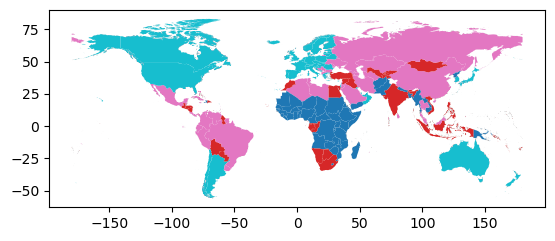

In [39]:
test.plot(column="HDI_level")

---

In [ ]:
import xarray as xr
import rioxarray as rxr
import pandas as pd
countries_grid = xr.open_zarr("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/misc/processed/stage_2/gadm/countries_grid.zarr", chunks="auto", consolidated=False)

# replace with full, global matrix
test = countries_grid.isel(latitude=slice(10_000,12_000),longitude=slice(15_000,17_000)).countries.compute()
classifications_df = pd.read_parquet("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/misc/processed/stage_1/country_classifications/classifications.parquet")
# Get classification columns (all except iso3 and country_id)
classification_cols = [col for col in classifications_df.columns 
                        if col not in ['iso3', 'country_id']]

import json
with open("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/misc/processed/stage_2/gadm/country_code_mapping.json", 'r') as f:
    country_code_to_id = json.load(f)
    
# Merge classifications with country codes
classifications_df['country_id'] = classifications_df['iso3'].map(
    lambda x: country_code_to_id.get(x, )
)
classification_arrays = {}
for col in classification_cols:
    classification_arrays[col] = test.isin(classifications_df.loc[classifications_df[col] == True, "country_id"].unique())
    
classification_dataset = xr.Dataset(classification_arrays)

/scicore/home/meiera/schulz0022/miniforge-pypy3/envs/gnt/lib/python3.11/site-packages/dask/array/reductions.py:655: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/scicore/home/meiera/schulz0022/miniforge-pypy3/envs/gnt/lib/python3.11/site-packages/dask/array/reductions.py:655: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/scicore/home/meiera/schulz0022/miniforge-pypy3/envs/gnt/lib/python3.11/site-packages/dask/array/reductions.py:655: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


In [19]:
import xarray as xr
import rioxarray as rxr
test = xr.open_zarr("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/misc/processed/stage_2/country_classifications/classifications_grid.zarr", consolidated = False, chunks="auto", mask_and_scale=True)
test = test.isel(latitude=slice(10_000,12_000),longitude=slice(15_000,17_000)).HDI_VH.compute()

In [21]:
test

<xarray.DataArray 'HDI_VH' (latitude: 2000, longitude: 2000)> Size: 4MB
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [False,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]],
      shape=(2000, 2000))
Coordinates:
  * longitude  (longitude) float64 16kB -117.5 -117.5 -117.5 ... -109.2 -109.2
  * latitude   (latitude) float64 16kB 33.33 33.33 33.33 ... 25.01 25.01 25.0
Attributes:
    description:  HDI_VH classification grid (True/False)

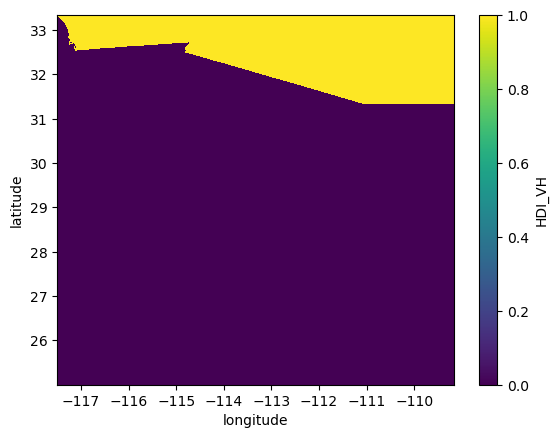

In [20]:
test.plot.imshow()

In [1]:
import pandas as pd

test = pd.read_parquet("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/assembled/_modis.parquet/ix=0/iy=0/data.parquet")

In [2]:
test.columns

Index(['year', 'median', 'mean', 'rollmax3', 'viirs_annual', 'ntl_harm',
       'reg_fav', 'subdivisions', 'countries', 'HDI_VH', 'HDI_HI', 'WB_LM',
       'WB_UM', 'HDI_ME', 'WB_HI', 'pixel_id', 'tile_ix', 'tile_iy',
       'median_unit_demeaned', 'mean_unit_demeaned', 'rollmax3_unit_demeaned',
       'viirs_annual_unit_demeaned', 'ntl_harm_unit_demeaned',
       'reg_fav_unit_demeaned', 'median_twoway_demeaned',
       'mean_twoway_demeaned', 'rollmax3_twoway_demeaned',
       'viirs_annual_twoway_demeaned', 'ntl_harm_twoway_demeaned',
       'reg_fav_twoway_demeaned'],
      dtype='object')